In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
train = pd.read_csv('../resources/data/seguro/train.csv')
# test = pd.read_csv('../resources/data/seguro/test.csv')

### Porto Seguro’s Safe Driver Prediction
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [98]:
print(np.sum(train['target']) / train.shape[0])

# from collections import Counter
# for col in train.columns:
#     print(col, Counter(train[col]).items())

0.036447517859182946


In [7]:
def filter_columns(data):
    columns = [col for col in list(data) if 'calc' not in col]
    columns = [col for col in columns if col not in ['id', 'target']]
    categorical = [col for col in columns if 'cat' in col]
    ordinal = [col for col in columns if ('cat' not in col) and ('bin' not in col)]
    return data[columns], categorical, ordinal

X, categorical, ordinal = filter_columns(train)
y = train['target']
print(X.shape)

(595212, 37)


In [8]:
from sklearn.model_selection import train_test_split

# val dataset in GridSearchCV
train_ratio, test_ratio, target_ratio = .8, .1, .1

test_and_target = test_ratio + target_ratio
op_train_ratio = 1. - train_ratio

X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, stratify=y, test_size=op_train_ratio)
X_test, X_target, y_test, y_target = train_test_split(X_heldout, y_heldout, stratify=y_heldout, 
                                                      test_size=target_ratio / test_and_target)

# to check if this stuff works correctly :)
# to_check = data['id']
# to_check_train, to_check_heldout = train_test_split(to_check, test_size=op_train_ratio)
# to_check_val, to_check_tmp = train_test_split(to_check_heldout, test_size=test_and_target / op_train_ratio)
# to_check_test, to_check_target = train_test_split(to_check_tmp, test_size=target_ratio / test_and_target)
# check = np.concatenate([to_check_train, to_check_test, to_check_val, to_check_target])
# print(check.shape[0] == np.unique(check).shape[0])

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

class DenseTransformer(TransformerMixin):
    def fit(self, *_):
        return self

    def transform(self, X, *_):
        return X.todense() if 'todense' in dir(X) else X
    
feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaled_numeric', StandardScaler(), ordinal)
])

def create_model(size_1, size_2):
    nn = keras.Sequential([
        keras.layers.Dense(size_1, activation=tf.nn.relu),
        keras.layers.Dense(size_2, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    nn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return nn

model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)

pipeline = Pipeline([('transformers', feature_transformation),
                     ('to_dense', DenseTransformer()),
                     ('estimator', model)])

params = {
    'estimator__epochs': [50],
    'estimator__batch_size': [1024],
    'estimator__size_1': [4, 8, 16],
    'estimator__size_2': [4, 8],
    'estimator__verbose': [0]
}

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
print(X_train.shape, X_resampled.shape)
print(np.sum(y_train), np.sum(y_resampled))

clf = GridSearchCV(pipeline, params, cv=5, verbose=1, n_jobs=-1)
# scoring='roc_auc'
clf.fit(X_resampled, y_resampled)

(476169, 37) (34710, 37)
17355 17355
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('categorical_features', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
 ...timator', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f530faa30f0>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__epochs': [50], 'estimator__batch_size': [1024], 'estimator__size_1': [4, 8, 16], 'estimator__size_2': [4, 8], 'estimator__verbose': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [11]:
acc_on_train_data = accuracy_score(y_train, clf.predict(X_train))
acc_on_noncorrupted_test_data = accuracy_score(y_test, clf.predict(X_test))
acc_on_noncorrupted_target_data = accuracy_score(y_target, clf.predict(X_target))

aucroc_on_train_data = roc_auc_score(y_train, clf.predict(X_train))
aucroc_on_noncorrupted_test_data = roc_auc_score(y_test, clf.predict(X_test))
aucroc_on_noncorrupted_target_data = roc_auc_score(y_target, clf.predict(X_target))

print("TRAIN.  accuracy: %.4f, auc_roc: %.4f" % (acc_on_train_data, aucroc_on_train_data))
print("TEST.   accuracy: %.4f, auc_roc: %.4f" % (acc_on_noncorrupted_test_data, aucroc_on_noncorrupted_test_data))
print("TARGET. accuracy: %.4f, auc_roc: %.4f" % (acc_on_noncorrupted_target_data, aucroc_on_noncorrupted_target_data))

TRAIN.  accuracy: 0.5913, auc_roc: 0.6109
TEST.   accuracy: 0.5851, auc_roc: 0.5844
TARGET. accuracy: 0.5864, auc_roc: 0.5730


### Plot AUC ROC curve
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [53]:
from copy import deepcopy

mask = lambda x: (x['ps_ind_14'] <= 1) | (x['ps_ind_15'] <= 1)

def corrupt(data, mask):
    corrupted_data = deepcopy(data)
    corrupted_data['ps_ind_02_cat'][mask] = 1
    corrupted_data['ps_ind_04_cat'][mask] = 1
    corrupted_data['ps_ind_05_cat'][mask] = 1
    return corrupted_data

corrupted_X_test = corrupt(X_test, mask(X_test))

TEST.   accuracy: 0.3859, auc_roc: 0.5611


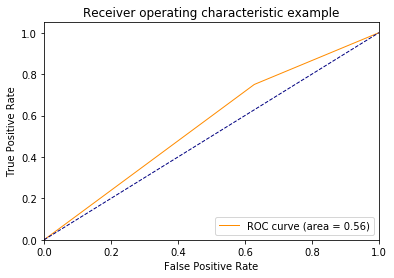

In [54]:
from sklearn.metrics import roc_curve, auc

predicted = clf.predict(corrupted_X_test)
# predicted_proba = clf.predict_proba(corrupted_X_test)

acc_on_corrupted_test_data = accuracy_score(y_test, predicted)
aucroc_on_corrupted_test_data = roc_auc_score(y_test, predicted)
print("TEST.   accuracy: %.4f, auc_roc: %.4f" % (acc_on_corrupted_test_data, aucroc_on_corrupted_test_data))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = np.unique(y).shape[0]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predicted)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 1

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# import scikitplot as skplt

# skplt.metrics.plot_roc_curve(y_test, predicted_proba)
# plt.show()

In [93]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import entropy

regressor_X_train = []
regressor_y_train = []

dataset_size_for_regressor = 500

def quant(percent): return lambda x: np.percentile(x, percent)

def stats(data):
    funcs = [np.min, np.max, np.mean, np.std, quant(25), quant(50), quant(75)]
    for column in data.T:
        for foo in funcs:
            yield foo(column)

def create_dataset_for_regressor(clf, X, y, size, mask_f):
    regressor_X, regressor_y = [], []
    mask = mask_f(X)
    for i in np.random.random_integers(1, 1000, size):
        np.random.seed(i)
        tmp = np.random.random()
        factor = int(round(tmp * np.sum(mask)))
        new_mask = deepcopy(mask)
        new_mask[np.random.choice(mask[mask == True].index, factor, replace=False)] = False
        corrupted_data = corrupt(X, new_mask)
        regressor_X.append(list(stats(clf.predict_proba(corrupted_data))))
        regressor_y.append(roc_auc_score(y, clf.predict(corrupted_data)))
        # regressor_y.append(accuracy_score(y, clf.predict(corrupted_data)))
    np.random.seed(1)
    return regressor_X, regressor_y

regressor_X_train, regressor_y_train = create_dataset_for_regressor(clf, X_test, y_test, 100, mask)

from sklearn.ensemble import RandomTreesEmbedding

meta_regressor = Pipeline([
    ('scaling', StandardScaler()),
    ('embeddings', RandomTreesEmbedding(max_depth=3, n_estimators=10, random_state=0)),
    ('learner', LinearRegression())
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('embeddings', RandomTreesEmbedding(max_depth=3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0...learner', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [94]:
regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask)

In [95]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

predicted_target = meta_regressor.predict(regressor_X_target)
predicted_train = meta_regressor.predict(regressor_X_train)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

score on corrupted target data:  0.01053981744906029


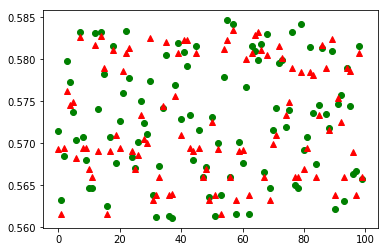

In [96]:
plt.plot(range(len(regressor_y_train)), regressor_y_train, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

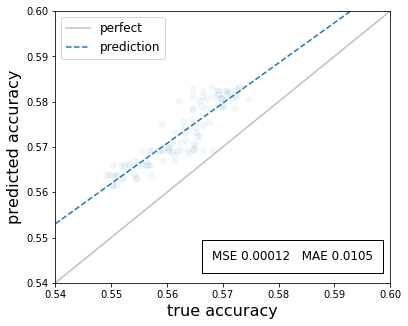

In [97]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.54, 0.6, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.54, 0.6))
plt.ylim((0.54, 0.6))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.568, .545, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/seguro-lr.pdf', dpi=300)
plt.show()